In [11]:
import numpy as np
import matplotlib.pyplot as plt 
import torch 
from torch.utils.data import DataLoader 
import io 
import torch.nn.functional as F 
import sys 
from datasets import get_dataset 
sys.path.insert(0, "../")
from DEFAULTS import BASE_PATH, COLORS 
from model_builder import get_pretrained_model_v2 
from configuration import Configuration 
from models.classifier import LinearProbe 

DATASET = "synaptic-semantic-segmentation"
MODEL = "mae-lightning-small"
WEIGHTS = "MAE_SMALL_STED"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
n_channels = 3 if "imagenet" in WEIGHTS.lower() else 1
PATCH_SIZE = 16
NUM_PATCHES = 14
CONSIDERED_P = np.arange(196)
remove_1 = np.arange(14)
remove_2 = np.arange(182, 196)
remove_3 = np.arange(14, 169, 14)
remove_4 = np.arange(27, 182, 14)
to_remove = np.concatenate([remove_1, remove_2, remove_3, remove_4])
CONSIDERED_P = np.setdiff1d(CONSIDERED_P, to_remove)
TARGET_PERFORATED = 367 
PERFORATED_PATCH = 78
TARGET_ELONGATED = 102 
ELONGATED_PATCH = 64

np.random.seed(42)
torch.manual_seed(42)


### Load model

In [12]:
model, cfg = get_pretrained_model_v2(
    name=MODEL,
    weights=WEIGHTS,
    path=None,
    mask_ratio=0.0, 
    pretrained=True if n_channels == 3 else False,
    in_channels=n_channels,
    as_classifier=True,
    blocks="all",
    global_pool="patch",
    num_classes=4
)
model.to(DEVICE)
model.eval()

mask_ratio 0.0
pretrained False
in_channels 1
blocks all
global_pool patch
num_classes 4
--- mae-lightning-small | /home-local/Frederic/baselines/mae-small_STED/pl_checkpoint-999.pth ---

--- Loaded model mae-lightning-small with weights MAE_SMALL_STED ---
--- Freezing every parameter in mae-lightning-small ---
--- Added linear probe to all frozen blocks ---


### Load and embed dataset 

In [13]:
_, _, test_dataset = get_dataset(name=DATASET, cfg=cfg, validation=True)

100%|██████████| 1357/1357 [00:00<00:00, 2369.45it/s]


Train dataset size: 1191
Valid dataset size: 354
Test dataset size: 375


##### Probe for query protein at the image-level

In [14]:
def patchify(imgs: torch.Tensor, patch_size: int = 16, image_channels: int = 1) -> torch.Tensor:
    """
    Used to create targets
    imgs: (N, C, H, W)
    x: (N, L, patch_size**2*C)
    """
    p = patch_size
    assert imgs.shape[2] == imgs.shape[3] and imgs.shape[2] % p == 0
    h = w = imgs.shape[2] // p
    x = imgs.reshape(shape=(imgs.shape[0], image_channels, h, p, w, p))
    x = torch.einsum('nchpwq->nhwpqc', x)
    x = x.reshape(shape=(imgs.shape[0], h*w, p, p))
    return x   

def unpatchify(x: torch.Tensor, patch_size: int = 16, image_channels: int = 1) -> torch.Tensor:
    p = patch_size
    h = w = int(x.shape[1]**0.5)
    assert h * w == x.shape[1]   
    x = x.reshape(shape=(x.shape[0], h, w, p, p, image_channels))
    x = torch.einsum('nhwpqc->nchpwq', x)
    imgs = x.reshape(shape=(x.shape[0], image_channels, h*p, h*p))
    return imgs  

def average_embeddings(embeddings: torch.Tensor, patch_idx: int,num_patches: int = 9, embed_dim: int = 384) -> torch.Tensor:
    temp_embed = torch.zeros(num_patches, embed_dim)
    temp_embed[0, :] = embeddings[0, patch_idx - 15, :]
    temp_embed[1, :] = embeddings[0, patch_idx - 14, :]
    temp_embed[2, :] = embeddings[0, patch_idx - 13, :]
    temp_embed[3, :] = embeddings[0, patch_idx - 1, :]
    temp_embed[4, :] = embeddings[0, patch_idx, :]
    temp_embed[5, :] = embeddings[0, patch_idx + 1, :]
    temp_embed[6, :] = embeddings[0, patch_idx + 13, :]
    temp_embed[7, :] = embeddings[0, patch_idx + 14, :]
    temp_embed[8, :] = embeddings[0, patch_idx + 15, :]
    temp_embed = torch.mean(temp_embed, dim=0).unsqueeze(0)
    return temp_embed

def get_crop_from_patchified_tensor(patchified_tensor: torch.Tensor, patch_idx: int, patch_size: int = 16) -> torch.Tensor:
    temp = torch.zeros(9, patch_size, patch_size)
    temp[0, :, :] = patchified_tensor[0, patch_idx - 15, :, :]
    temp[1, :, :] = patchified_tensor[0, patch_idx - 14, :, :]
    temp[2, :, :] = patchified_tensor[0, patch_idx - 13, :, :]
    temp[3, :, :] = patchified_tensor[0, patch_idx - 1, :, :]
    temp[4, :, :] = patchified_tensor[0, patch_idx, :, :]
    temp[5, :, :] = patchified_tensor[0, patch_idx + 1, :, :]
    temp[6, :, :] = patchified_tensor[0, patch_idx + 13, :, :]
    temp[7, :, :] = patchified_tensor[0, patch_idx + 14, :, :]
    temp[8, :, :] = patchified_tensor[0, patch_idx + 15, :, :]
    temp = unpatchify(temp.unsqueeze(0), patch_size=PATCH_SIZE, image_channels=1).squeeze().cpu().numpy()
    return temp

In [15]:
from tqdm import trange

MASK_ID = 2
imgs_ids, patch_ids = [], []

with torch.no_grad():
    for idx in trange(len(test_dataset)):
        batch = test_dataset[idx]
        X, y = batch
        X = X.unsqueeze(0).to(DEVICE) 
        mask = y.unsqueeze(0)[:, [MASK_ID], :, :].to(DEVICE)
        patchified_img = patchify(X, patch_size=PATCH_SIZE, image_channels=1)
        patchified_mask = patchify(mask, patch_size=PATCH_SIZE, image_channels=1)
        for k in CONSIDERED_P:
            img_crop = patchified_img[0, k, :, :].cpu().numpy()
            mask_crop = patchified_mask[0, k, :, :].cpu().numpy()
            if np.count_nonzero(mask_crop >= 1.0) > 0:
                imgs_ids.append(idx)
                patch_ids.append(k)

print(len(imgs_ids), len(patch_ids))
assert len(imgs_ids) == len(patch_ids)
num_multidomain = len(imgs_ids)
target_idx = np.random.randint(0, num_multidomain) 
TARGET = TARGET_PERFORATED
# TARGET = imgs_ids[target_idx]
PATCH = PERFORATED_PATCH
# PATCH = patch_ids[target_idx]
print(TARGET, PATCH)


  0%|          | 0/375 [00:00<?, ?it/s]

100%|██████████| 375/375 [00:04<00:00, 85.73it/s]

276 276
367 78


  0%|          | 0/375 [00:00<?, ?it/s]

 98%|█████████▊| 367/375 [00:02<00:00, 150.08it/s]

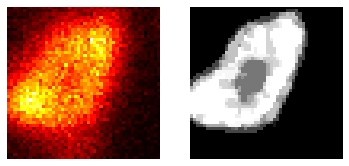

100%|██████████| 375/375 [00:02<00:00, 148.33it/s]

53991 53991 53991


In [16]:
key_embed = []
key_imgs = []
key_patches = []
with torch.no_grad():
    for idx in trange(len(test_dataset)):
        batch = test_dataset[idx]
        X, y = batch
        X = X.unsqueeze(0).to(DEVICE)
        pred = model.forward_features(X)
        mask = y.unsqueeze(0)[:, [MASK_ID], :, :].to(DEVICE)
        mask_numpy = mask.squeeze().cpu().numpy()
        patchified_img = patchify(X, patch_size=PATCH_SIZE, image_channels=1)
        patchified_mask = patchify(mask, patch_size=PATCH_SIZE, image_channels=1)
        for k in CONSIDERED_P:
            # temp_embed = average_embeddings(pred, patch_idx=k,num_patches=196, embed_dim=384)
            temp_embed = pred[0, k, :]
            if idx == TARGET and k == PATCH:
                query_embed = temp_embed.clone()
                temp_img = get_crop_from_patchified_tensor(patchified_img, patch_idx=k, patch_size=PATCH_SIZE)
                temp_mask = get_crop_from_patchified_tensor(patchified_mask, patch_idx=k, patch_size=PATCH_SIZE)
                fig, axs = plt.subplots(1, 2)
                axs[0].imshow(temp_img, cmap="hot")
                axs[1].imshow(temp_mask, cmap="gray")
                for ax in axs:
                    ax.axis("off")
                plt.show()
            elif idx == TARGET and k in [PATCH - 15, PATCH - 14, PATCH - 13, PATCH - 1, PATCH, PATCH + 1, PATCH + 13, PATCH + 14, PATCH + 15]:
                continue
            else:
                key_embed.append(temp_embed)
                key_imgs.append(idx)
                key_patches.append(k)


print(len(key_embed), len(key_imgs), len(key_patches))
    

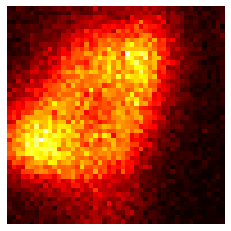

In [17]:
query_img = test_dataset[TARGET][0].unsqueeze(0).to(DEVICE)
query_mask = test_dataset[TARGET][1][2].cpu().numpy()
query_patchified_img = patchify(query_img, patch_size=PATCH_SIZE, image_channels=1)
query_protein = get_crop_from_patchified_tensor(query_patchified_img, patch_idx=PATCH, patch_size=PATCH_SIZE)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(query_protein, cmap="hot")
ax.axis("off")
plt.show()



In [18]:
query_embed = query_embed.squeeze()
key_embeddings = torch.stack(key_embed).squeeze()
similarities = F.cosine_similarity(query_embed, key_embeddings, dim=-1)
sorted_similarities, sorted_indices = torch.sort(similarities, descending=True)
key_imgs = [key_imgs[i] for i in sorted_indices]
key_patches = [key_patches[i] for i in sorted_indices]
    

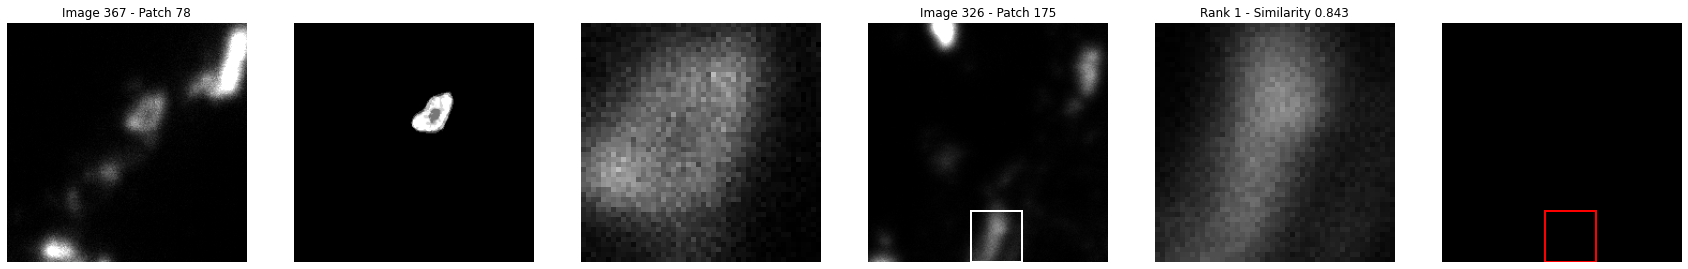

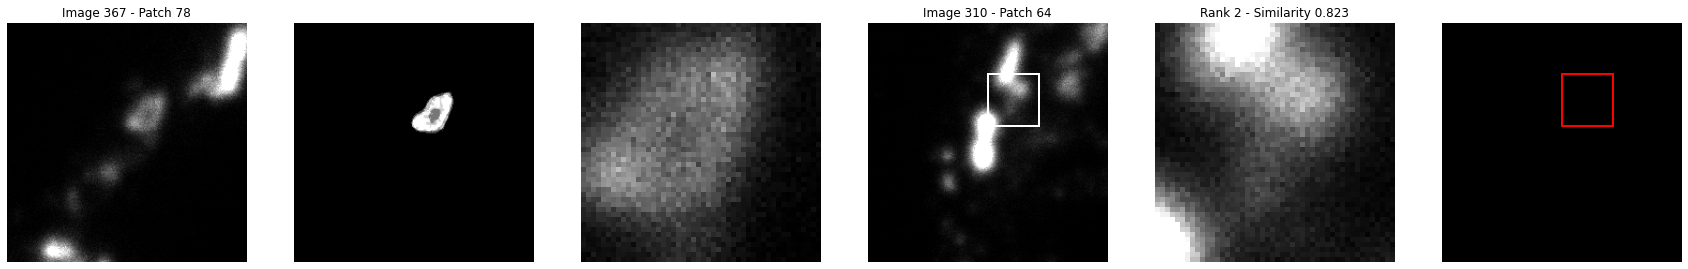

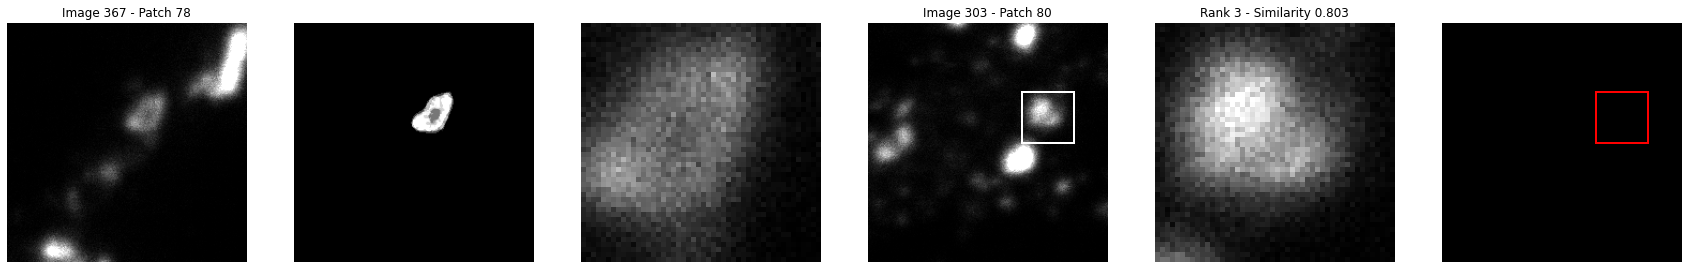

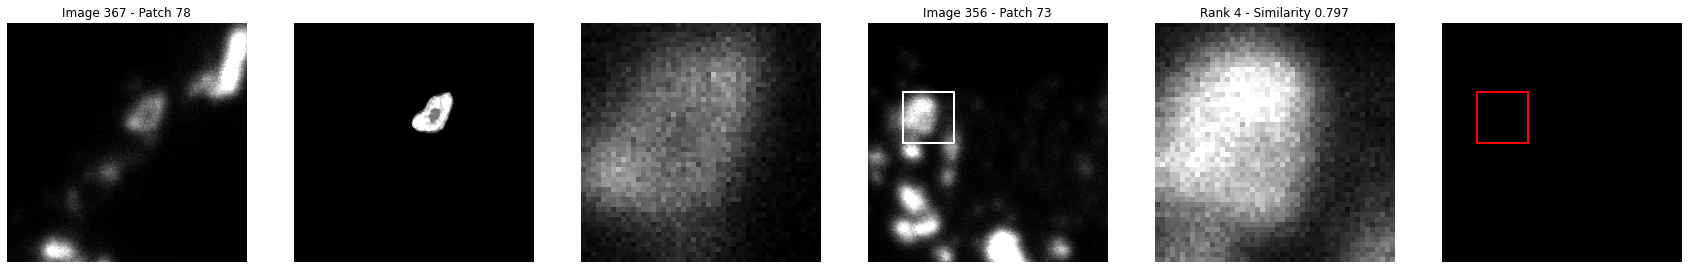

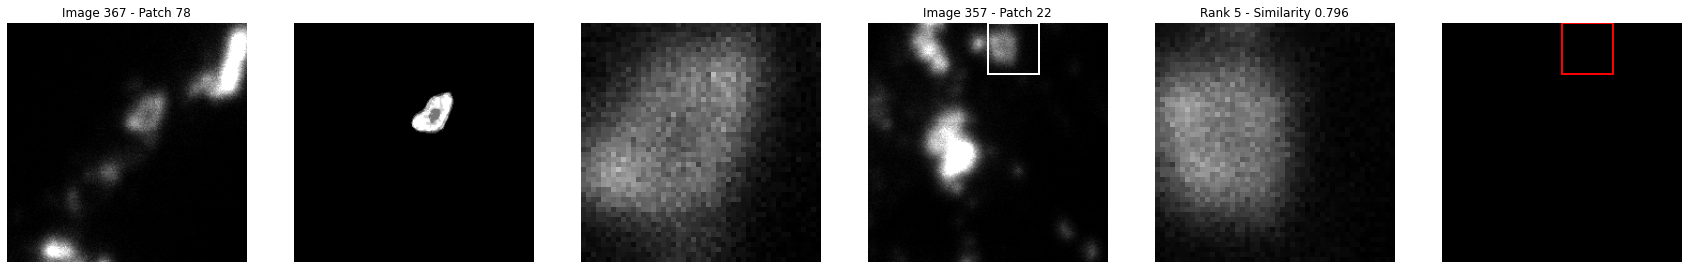

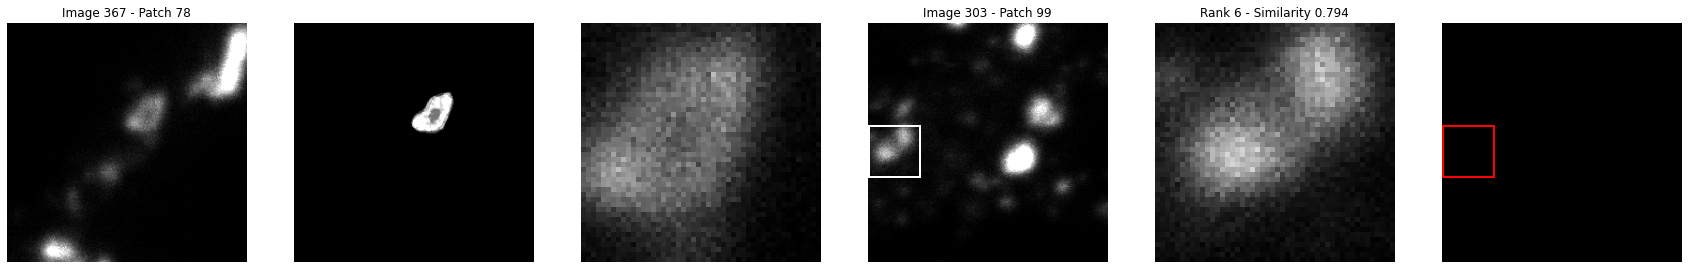

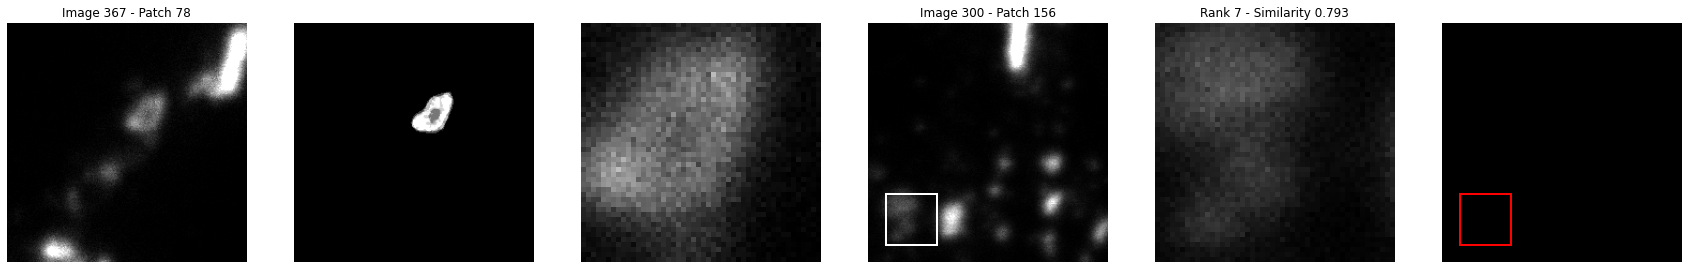

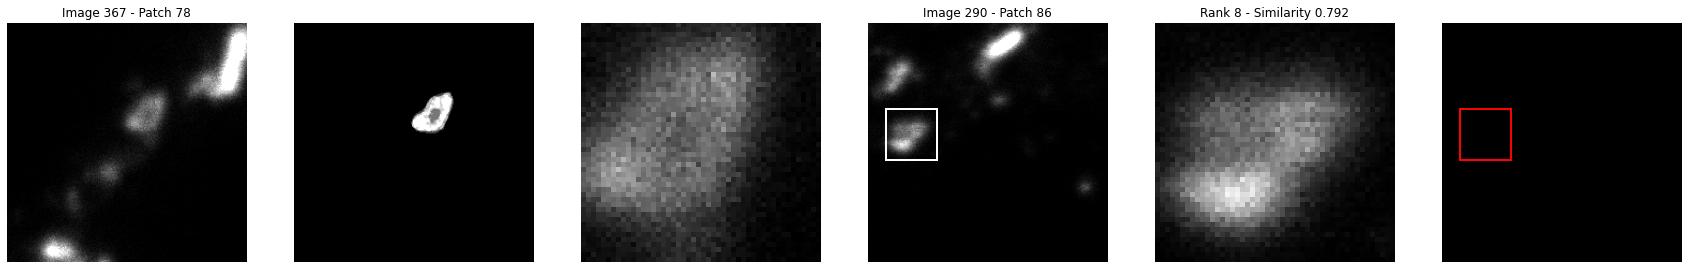

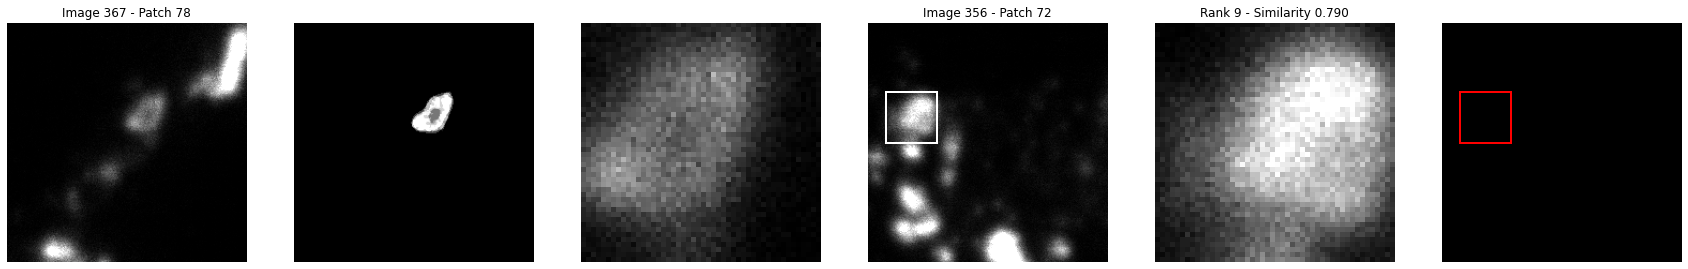

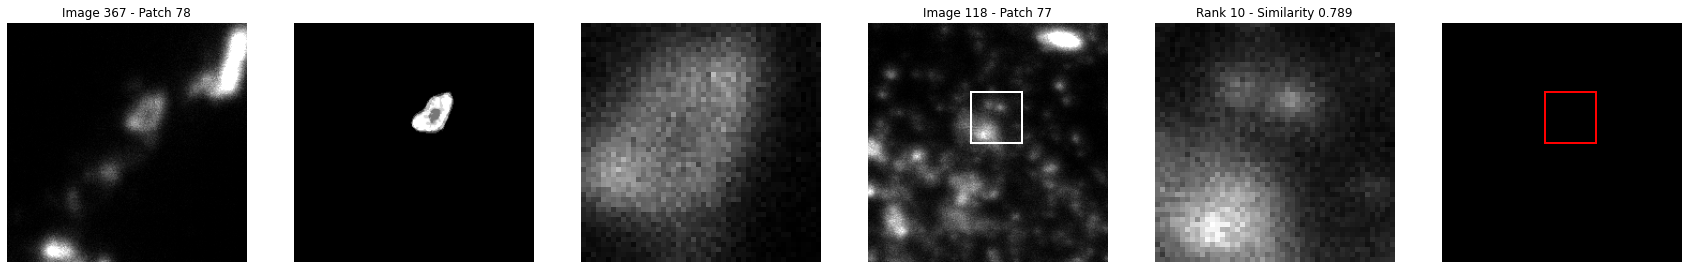

Accuracy: 0.0 (0/10)


In [22]:
N = 10

correct = 0
for rank, (sim, idx, patch) in enumerate(zip(sorted_similarities[:N], key_imgs[:N], key_patches[:N])):
    img = test_dataset[idx][0]
    y = test_dataset[idx][1]
    mask = y.unsqueeze(0)[:, [MASK_ID], :, :].to(DEVICE)
    patchified_img = patchify(img.unsqueeze(0), patch_size=PATCH_SIZE, image_channels=1)
    patchified_mask = patchify(mask, patch_size=PATCH_SIZE, image_channels=1)
    temp_img = get_crop_from_patchified_tensor(patchified_img, patch_idx=patch, patch_size=PATCH_SIZE)
    temp_mask = get_crop_from_patchified_tensor(patchified_mask, patch_idx=patch, patch_size=PATCH_SIZE)
    label = np.count_nonzero(temp_mask >= 0.5) > 0
    if label:
        correct += 1
    fig, axs = plt.subplots(1,6, figsize=(30, 10))
    axs[0].imshow(query_img.squeeze().cpu().numpy(), cmap="gray", vmin=0, vmax=0.5)
    axs[1].imshow(query_mask, cmap="gray")
    axs[2].imshow(query_protein, cmap="gray", vmin=0, vmax=0.5)
    axs[3].imshow(img.squeeze().cpu().numpy(), cmap="gray", vmin=0, vmax=0.5)
    axs[4].imshow(temp_img, cmap="gray", vmin=0, vmax=0.5)
    axs[5].imshow(mask.squeeze().cpu().numpy(), cmap="gray")

    counter = 0
    for y in np.arange(0, 224, 16):
        for x in np.arange(0, 224, 16):
            if counter == patch:
                rect = plt.Rectangle((x - 16, y - 16), 48, 48, fill=False, edgecolor='white', linewidth=2)
                rect_red = plt.Rectangle((x - 16, y - 16), 48, 48, fill=False, edgecolor='red', linewidth=2)
                axs[3].add_patch(rect)
                axs[5].add_patch(rect_red)
            counter += 1

    axs[0].set_title(f"Image {TARGET} - Patch {PATCH}")
    axs[3].set_title(f"Image {idx} - Patch {patch}")
    axs[4].set_title(f"Rank {rank + 1} - Similarity {sim:.3f}")
    for ax in axs:
        ax.axis("off")
    plt.show()
    fig.savefig(f"./patch-retrieval-experiment/examples/{WEIGHTS}-retrieval-{rank}.pdf", dpi=1200, bbox_inches='tight', transparent=True)

print(f"Accuracy: {correct / N} ({correct}/{N})")
    